In [80]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import Dataset, DataLoader

# # -------------------------------
# # 1️⃣ 读取谱线列表文件
# # -------------------------------
# def read_line_list(filepath):
#     lines, freqs = [], []
#     with open(filepath, 'r') as f:
#         for line in f:
#             if line.strip() == '':
#                 continue
#             parts = line.split()
#             if len(parts) < 2:
#                 continue
#             lines.append(parts[0])
#             freqs.append(float(parts[1]))
#     return lines, np.array(freqs)


# class SpectrumByLineDataset(Dataset):
#     def __init__(self, spectrum_file, line_file, window=0.03, target_len=256,
#                  normalize=True, velocity=None):
#         self.line_names, self.line_rest = read_line_list(line_file)
#         c = 299792458  # m/s

#         # --- 读取主光谱，跳过第一行 ---
#         data = np.loadtxt(spectrum_file, skiprows=1)
#         freq_obs, flux = data[:, 0], data[:, 1]

#         # --- 速度校正 ---
#         if velocity is not None:
#             v = velocity * 1e3  # km/s → m/s
#             freq = freq_obs * (1 + v / c)
#             print(f"[INFO] Applied velocity correction: v = {velocity:.3f} km/s")
#         else:
#             freq = freq_obs

#         self.samples, self.names = [], []
#         self.normalize = normalize

#         for name, f_rest in zip(self.line_names, self.line_rest):
#             mask = (freq > f_rest - window) & (freq < f_rest + window)
#             if np.sum(mask) < 8:
#                 continue

#             f_sub = freq[mask]
#             flux_sub = flux[mask]

#             # 插值
#             f_new = np.linspace(f_sub.min(), f_sub.max(), target_len)
#             flux_new = np.interp(f_new, f_sub, flux_sub)

# #             # 可选归一化
# #             if normalize:
# #                 flux_new = (flux_new - np.mean(flux_new)) / (np.std(flux_new) + 1e-6)

#             # 保存子光谱
#             self.samples.append(torch.tensor(flux_new, dtype=torch.float32).unsqueeze(0))
#             self.names.append(name)

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         return self.samples[idx], self.names[idx]



# # -------------------------------
# # 3️⃣ 使用示例
# # -------------------------------
# spectrum_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\spw1\\spectrum.Lh07.spw0.commonbeam.1arcsec.dat"
# line_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\linelist_lsb.dat"  # 包含 line name + freq
# dataset = SpectrumByLineDataset(
#     spectrum_file, line_file, velocity=239.5157166
# )


# print(f"共找到 {len(dataset)} 条谱线样本")
# for i in range(len(dataset)):
#     x, name = dataset[i]
#     print(f"{i+1}. {name}  子光谱长度: {x.shape[-1]}")

# # 可视化前几条谱线
# #plt.figure(figsize=(8, 6))
# for i in range(len(dataset)):
#     x, name = dataset[i]
#     plt.plot(x.squeeze().numpy(), label=name)
#     plt.legend()
#     plt.title("Extracted Line Spectra")
#     plt.xlabel("Resampled index")
#     plt.ylabel("Normalized Flux")
#     plt.tight_layout()
#     plt.show()


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os

# -------------------------------
# 1️⃣ 读取谱线列表文件
# -------------------------------
def read_line_list(filepath):
    lines, freqs = [], []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip() == '':
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            lines.append(parts[0])
            freqs.append(float(parts[1]))
    return lines, np.array(freqs)

# -------------------------------
# 2️⃣ 多文件光谱数据集类
# -------------------------------
class MultiSourceSpectrumDataset(Dataset):
    def __init__(self, data_dir, line_file, window=0.03, target_len=256,
                 normalize=True, velocity_dict=None):
        """
        初始化多源光谱数据集
        
        参数:
        - data_dir: 包含所有光谱文件的目录
        - line_file: 谱线列表文件路径
        - window: 提取窗口大小
        - target_len: 目标子光谱长度
        - normalize: 是否归一化
        - velocity_dict: 字典，键为源名称，值为速度修正值 (km/s)
        """
        self.line_names, self.line_rest = read_line_list(line_file)
        self.c = 299792458  # m/s
        self.window = window
        self.target_len = target_len
        self.normalize = normalize
        
        # 如果没有提供速度字典，创建空字典
        if velocity_dict is None:
            velocity_dict = {}
        
        # 存储所有样本和对应的信息
        self.samples = []        # 光谱数据
        self.full_names = []     # 完整标识符，格式: "源-频率窗口-谱线名称"
        self.source_info = []    # 源信息，格式: (源名称, 频率窗口, 谱线名称)
        self.scales=[]           # 初始化缩放因子列表
        
        # 查找所有光谱文件
        # 假设文件命名格式: "spectrum.源名称.频率窗口.commonbeam.1arcsec.dat"
        pattern = os.path.join(data_dir, "spectrum.*.spw*.commonbeam.1arcsec.dat")
        spectrum_files = glob.glob(pattern)
        
        if not spectrum_files:
            print(f"警告: 在目录 {data_dir} 中没有找到匹配的光谱文件")
            return
        
        print(f"找到 {len(spectrum_files)} 个光谱文件")
        
        # 处理每个光谱文件
        for spectrum_file in spectrum_files:
            # 从文件名中提取源名称和频率窗口
            filename = os.path.basename(spectrum_file)
            parts = filename.split('.')
            if len(parts) < 3:
                print(f"跳过无法解析的文件: {filename}")
                continue
                
            source_name = parts[1]  # 例如 "Lh07"
            spw = parts[2]          # 例如 "spw0"
            
            print(f"处理文件: {filename}, 源: {source_name}, 频率窗口: {spw}")
            
            # 获取该源的速度修正值
            velocity = velocity_dict.get(source_name, None)
            
            # 处理单个光谱文件
            self._process_single_file(spectrum_file, source_name, spw, velocity)
        
        print(f"总共提取了 {len(self.samples)} 个谱线样本")
    
    def _process_single_file(self, spectrum_file, source_name, spw, velocity=None):
        """处理单个光谱文件"""
        try:
            # 读取主光谱，跳过第一行
            data = np.loadtxt(spectrum_file, skiprows=1)
            freq_obs, flux = data[:, 0], data[:, 1]
            
            # 速度校正
            if velocity is not None:
                v = velocity * 1e3  # km/s → m/s
                freq = freq_obs * (1 + v / self.c)
                print(f"  [INFO] 应用速度修正: v = {velocity:.3f} km/s")
            else:
                freq = freq_obs
            
            # 对每条谱线提取子光谱
            for line_name, f_rest in zip(self.line_names, self.line_rest):
                mask = (freq > f_rest - self.window) & (freq < f_rest + self.window)
                if np.sum(mask) < 8:
                    continue  # 跳过数据点太少的谱线
                
                f_sub = freq[mask]
                flux_sub = flux[mask]
                
                # 插值到目标长度
                f_new = np.linspace(f_sub.min(), f_sub.max(), self.target_len)
                flux_new = np.interp(f_new, f_sub, flux_sub)
                
                # 归一化 (可选)
                if self.normalize:
                    #flux_new = (flux_new - np.mean(flux_new)) / (np.std(flux_new) + 1e-6)
                    scale = max(np.max(np.abs(flux_new)), 1e-6)
                    flux_norm = flux_new / scale
                else:
                    scale=1.0
                    flux_norm=flux_new

                
                # 创建完整标识符
                full_name = f"{source_name}-{spw}-{line_name}"
                
                # 保存样本和相关信息
                self.samples.append(torch.tensor(flux_new, dtype=torch.float32).unsqueeze(0))
                self.full_names.append(full_name)
                self.source_info.append((source_name, spw, line_name))
                self.scales.append(scale)  # 保存了缩放因子

                
        except Exception as e:
            print(f"处理文件 {spectrum_file} 时出错: {e}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.full_names[idx], self.scales[idx]
    
    def get_source_info(self, idx):
        """获取指定索引样本的源信息"""
        return self.source_info[idx]
    
    def get_samples_by_source(self, source_name):
        """获取特定源的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[0] == source_name]
    
    def get_samples_by_spw(self, spw):
        """获取特定频率窗口的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[1] == spw]
    
    def get_samples_by_line(self, line_name):
        """获取特定谱线的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[2] == line_name]

    
def collate_fn(batch):
    """处理批次数据，包括缩放因子"""
    xs = torch.stack([b[0] for b in batch])  # 光谱数据
    names = [b[1] for b in batch]            # 名称列表
    
    scales_list = [b[2] for b in batch]
    scales = torch.tensor(scales_list, dtype=torch.float32)
    scales = scales.view(-1, 1, 1)  # 重塑为 [batch_size, 1, 1]
    
    return xs, names, scales
    
    
# -------------------------------
# 3️⃣ 使用示例
# -------------------------------
if __name__ == "__main__":
    # 数据目录和谱线列表
    data_dir = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\manysource"
    line_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\linelist_lsb.dat"
    
    # 定义各源的速度修正值 (km/s)
    velocity_dict = {
        "Lh07": 239.5157166,
        "Lh09": 235.751358,  
        "Lh10": 251.2273865,  
        # 添加更多源和对应的速度...
    }
    
    # 创建多源数据集
    dataset = MultiSourceSpectrumDataset(
        data_dir=data_dir,
        line_file=line_file,
        velocity_dict=velocity_dict,
        target_len=256,
        normalize=True
    )
    
    # 打印数据集信息
    print(f"\n数据集统计:")
    print(f"总样本数: {len(dataset)}")
    
    # 按源统计
    sources = set(info[0] for info in dataset.source_info)
    for source in sources:
        count = len(dataset.get_samples_by_source(source))
        print(f"  {source}: {count} 个样本")
    
    # 按频率窗口统计
    spws = set(info[1] for info in dataset.source_info)
    for spw in spws:
        count = len(dataset.get_samples_by_spw(spw))
        print(f"  {spw}: {count} 个样本")
    
    # 显示前几个样本
    print(f"\n前5个样本:")
    for i in range(min(5, len(dataset))):
        spectrum, full_name, scales = dataset[i]
        source_info = dataset.get_source_info(i)
        print(f"  {i+1}. {full_name} (源: {source_info[0]}, 窗口: {source_info[1]}, 谱线: {source_info[2]})")
    
    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)  # 怎么把数据集包装成可迭代的批次数据，每个批次包含8各样本（
    
    # 测试数据加载器
    for batch_idx, (spectra, names, scales) in enumerate(dataloader):
        print(f"\n批次 {batch_idx}:")
        print(f"  光谱形状: {spectra.shape}")
        print(f"  样本名称: {names[:3]}...")  # 只显示前3个
        if batch_idx >= 2:  # 只测试前3个批次
            break

找到 15 个光谱文件
处理文件: spectrum.Lh07.spw0.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw0
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw1.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw1
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw2.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw2
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw3.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw3
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw4.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw4
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh09.spw0.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw0
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw1.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw1
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw2.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw2
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw3.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw3
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw4.commonbeam.1arcsec.dat, 源: Lh09, 频率窗

Lh07-spw0-34SO2
0.01100638037160907
torch.Size([1, 256]) -0.004383359104394913 0.011006380431354046 0.001239584293216467 0.0028835434932261705


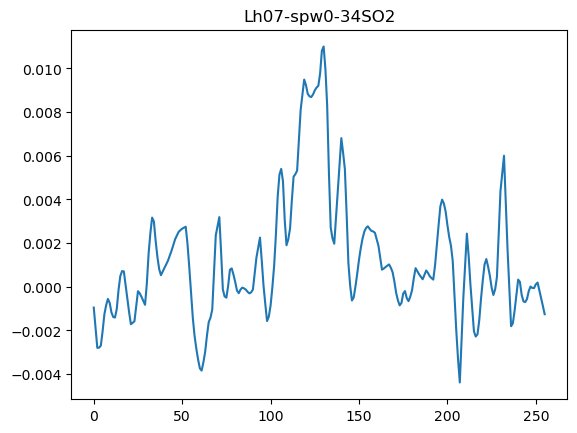

In [62]:
x, name, scales = dataset[0]
print(name)
print(scales)
print(x.shape, x.min().item(), x.max().item(), x.mean().item(), x.std().item())

import matplotlib.pyplot as plt
plt.plot(x.squeeze().numpy())
plt.title(name)
plt.show()


In [63]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8    # 把数据**分成若干“小批次”（batches）**来训练。
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


In [93]:
class ConvolutionalVAE1D(nn.Module):
    def __init__(self, input_length=256, latent_dim=32, base_channels=16):
        super().__init__()

        # -------- Encoder --------
        self.encoder = nn.Sequential(
            nn.Conv1d(1, base_channels, 4, 2, 1), nn.ReLU(),       # 256 → 128
            nn.Conv1d(base_channels, base_channels*2, 4, 2, 1), nn.ReLU(),  # 128 → 64
            nn.Conv1d(base_channels*2, base_channels*4, 3, 1, 1), nn.ReLU()  # 64 → 64
        )

        # 自动计算 flatten 的维度
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            h = self.encoder(dummy)
            self.flat_dim = h.numel()   # e.g. 1 × 64 × 64 = 4096

        # mean / logvar layer
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        # latent → feature map
        self.fc_decode = nn.Linear(latent_dim, self.flat_dim)

        # -------- Decoder --------
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(base_channels*4, base_channels*2, 4, 2, 1), nn.ReLU(),  # 64→128
            nn.ConvTranspose1d(base_channels*2, base_channels, 4, 2, 1), nn.ReLU(),   # 128→256
            nn.ConvTranspose1d(base_channels, 1, 3, 1, 1),
            nn.Tanh()  # 🔥 稳定输出
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        h_flat = h.view(x.size(0), -1)

        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)

        z = self.reparameterize(mu, logvar)

        h_dec = self.fc_decode(z)
        h_dec = h_dec.view(x.size(0), -1, h.shape[-1])

        recon = self.decoder(h_dec)

        return recon, mu, logvar, z


In [94]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (mse + beta * kld) / x.size(0)

# 初始化模型
model = ConvolutionalVAE1D(input_length=256, latent_dim=32, base_channels=16).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# 训练
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for x_batch, names, scales in pbar:  # 注意 dataset 返回 (tensor, name, scales)
        x_batch = x_batch.to(DEVICE)
        scales = scales.to(DEVICE)
        
        optimizer.zero_grad()
        recon_norm, mu, logvar, _ = model(x_batch)
        
        
        # 在原始尺度上计算损失
        loss = vae_loss(recon_norm, x_batch, mu, logvar, beta=0.00001)  # ✅ 调小 KL 权重
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    print(f"Epoch {epoch+1}: avg loss = {total_loss/len(dataloader):.4f}")



Epoch 1/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.01it/s, loss=3.6351]


Epoch 1: avg loss = 9.6695


Epoch 2/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.30it/s, loss=0.6821]


Epoch 2: avg loss = 3.3789


Epoch 3/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.86it/s, loss=9.0253]


Epoch 3: avg loss = 1.8390


Epoch 4/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.60it/s, loss=0.3048]


Epoch 4: avg loss = 1.4809


Epoch 5/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.03it/s, loss=0.2102]


Epoch 5: avg loss = 1.2744


Epoch 6/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.40it/s, loss=0.1991]


Epoch 6: avg loss = 0.9980


Epoch 7/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.60it/s, loss=1.2946]


Epoch 7: avg loss = 0.6537


Epoch 8/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.41it/s, loss=0.0855]


Epoch 8: avg loss = 0.4033


Epoch 9/50: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.09it/s, loss=0.0354]


Epoch 9: avg loss = 0.2234


Epoch 10/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.34it/s, loss=0.0289]


Epoch 10: avg loss = 0.1696


Epoch 11/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.77it/s, loss=0.2567]


Epoch 11: avg loss = 0.1749


Epoch 12/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.09it/s, loss=0.0634]


Epoch 12: avg loss = 0.1644


Epoch 13/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.12it/s, loss=0.0176]


Epoch 13: avg loss = 0.1468


Epoch 14/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.83it/s, loss=0.6091]


Epoch 14: avg loss = 0.1595


Epoch 15/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.66it/s, loss=0.0343]


Epoch 15: avg loss = 0.1270


Epoch 16/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.90it/s, loss=0.0569]


Epoch 16: avg loss = 0.1436


Epoch 17/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.37it/s, loss=0.1130]


Epoch 17: avg loss = 0.1271


Epoch 18/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.70it/s, loss=0.0928]


Epoch 18: avg loss = 0.1157


Epoch 19/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.62it/s, loss=0.5510]


Epoch 19: avg loss = 0.0966


Epoch 20/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.65it/s, loss=0.0432]


Epoch 20: avg loss = 0.0860


Epoch 21/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.68it/s, loss=0.0216]


Epoch 21: avg loss = 0.0754


Epoch 22/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.65it/s, loss=0.0200]


Epoch 22: avg loss = 0.0640


Epoch 23/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.44it/s, loss=0.0371]


Epoch 23: avg loss = 0.0752


Epoch 24/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.09it/s, loss=0.0449]


Epoch 24: avg loss = 0.0593


Epoch 25/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.97it/s, loss=0.0089]


Epoch 25: avg loss = 0.0475


Epoch 26/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.24it/s, loss=0.0109]


Epoch 26: avg loss = 0.0490


Epoch 27/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.87it/s, loss=0.0306]


Epoch 27: avg loss = 0.0698


Epoch 28/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.10it/s, loss=0.0530]


Epoch 28: avg loss = 0.0541


Epoch 29/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.38it/s, loss=0.0131]


Epoch 29: avg loss = 0.0479


Epoch 30/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.69it/s, loss=0.0136]


Epoch 30: avg loss = 0.0666


Epoch 31/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.43it/s, loss=0.0332]


Epoch 31: avg loss = 0.0414


Epoch 32/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.03it/s, loss=0.0225]


Epoch 32: avg loss = 0.0444


Epoch 33/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.64it/s, loss=0.0413]


Epoch 33: avg loss = 0.0536


Epoch 34/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.43it/s, loss=0.0229]


Epoch 34: avg loss = 0.0417


Epoch 35/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.58it/s, loss=0.1406]


Epoch 35: avg loss = 0.0525


Epoch 36/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.91it/s, loss=0.0080]


Epoch 36: avg loss = 0.0356


Epoch 37/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.21it/s, loss=0.0080]


Epoch 37: avg loss = 0.0408


Epoch 38/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.55it/s, loss=0.0143]


Epoch 38: avg loss = 0.0453


Epoch 39/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.11it/s, loss=0.0108]


Epoch 39: avg loss = 0.0400


Epoch 40/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.77it/s, loss=0.2314]


Epoch 40: avg loss = 0.0599


Epoch 41/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.89it/s, loss=0.0246]


Epoch 41: avg loss = 0.0373


Epoch 42/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.07it/s, loss=0.0603]


Epoch 42: avg loss = 0.0624


Epoch 43/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.19it/s, loss=0.2031]


Epoch 43: avg loss = 0.0726


Epoch 44/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.47it/s, loss=0.0169]


Epoch 44: avg loss = 0.0432


Epoch 45/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.06it/s, loss=0.0961]


Epoch 45: avg loss = 0.0293


Epoch 46/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.93it/s, loss=0.0083]


Epoch 46: avg loss = 0.0270


Epoch 47/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.26it/s, loss=0.0076]


Epoch 47: avg loss = 0.0487


Epoch 48/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.87it/s, loss=0.0106]


Epoch 48: avg loss = 0.0343


Epoch 49/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.12it/s, loss=0.0168]


Epoch 49: avg loss = 0.0303


Epoch 50/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.35it/s, loss=0.0106]

Epoch 50: avg loss = 0.0413


In [103]:
x_batch, names, scales = next(iter(dataloader))
x_batch = x_batch.to(DEVICE)
scales = scales.to(DEVICE)

recon_norm, _, _, _ = model(x_batch)
recon = recon_norm * scales  # 反归一化

print("Input range:", x_batch.min().item(), x_batch.max().item())
print("Reconstruction range:", recon.min().item(), recon.max().item())


Input range: -0.006543162744492292 0.9911571145057678
Reconstruction range: -0.04695302993059158 0.9672956466674805


✅ 共对比 120 条谱线


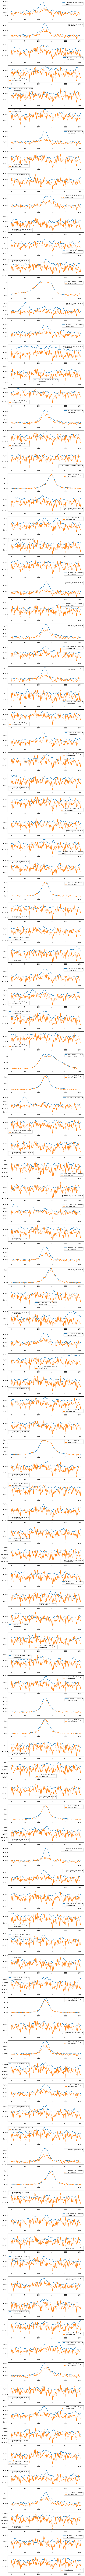

In [111]:
# ============================================
# ✅ 可视化所有样本的原始谱线与重建谱线
# ============================================
import matplotlib.pyplot as plt

model.eval()
all_original = []
all_reconstructed = []
all_names = []

with torch.no_grad():
    for x_batch, names, scales_batch in dataloader:
        x_batch = x_batch.to(DEVICE)
        scales_batch = scales_batch.to(DEVICE)
        
        recon_norm, _, _, _ = model(x_batch)
        
        # 都反归一化
        original = x_batch 
        recon = recon_norm 
        
        all_original.append(original.cpu())
        all_reconstructed.append(recon.cpu())
        all_names.extend(names)


# 合并成一个大 tensor
all_original = torch.cat(all_original, dim=0).numpy().squeeze(1)
all_reconstructed = torch.cat(all_reconstructed, dim=0).numpy().squeeze(1)

print(f"✅ 共对比 {len(all_names)} 条谱线")

# ==============================
# 绘制所有谱线（每条独立一行）
# ==============================
n = len(all_names)
plt.figure(figsize=(8, 2 * n))

for i in range(n):
    plt.subplot(n, 1, i + 1)
    plt.plot(all_original[i], label=f"{all_names[i]} - Original", color="C0")
    plt.plot(all_reconstructed[i], label="Reconstructed", color="C1", linestyle="--")
    plt.legend(fontsize=8)
    plt.tight_layout()

plt.show()


In [8]:
features = []
names_all = []

model.eval()
with torch.no_grad():
    for x_batch, names in dataloader:
        x_batch = x_batch.to(DEVICE)
        _, _, _, z = model(x_batch)
        features.append(z.cpu())
        names_all.extend(names)

features = torch.cat(features).numpy()
print(features)
print(names_all[5][10:])
print(names_all[0])

[[-0.15172324 -0.22371933  4.0635395  ... -2.0649257   2.023567
  -1.6858219 ]
 [ 1.5513856  -2.0317671   2.4442115  ... -4.4570217  -2.692738
  -0.6422797 ]
 [-0.66883576  4.656898   -3.1312373  ...  0.19293448  1.9924059
   6.8693633 ]
 ...
 [-3.1512253  -1.8926222   4.667433   ... -3.3403792  -0.99733794
  -1.2007583 ]
 [ 0.38721913  3.910409   -3.2305796  ...  1.4283028  -2.3051648
   3.5756786 ]
 [ 3.8245032  -2.7703433   3.95769    ... -5.3156652  -0.6920303
  -0.90867305]]
SO2
Lh09-spw1-34SO2


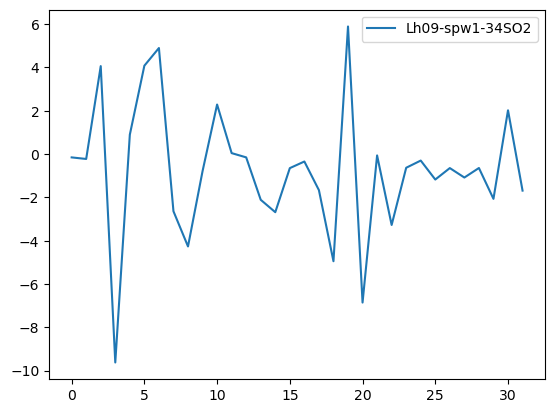

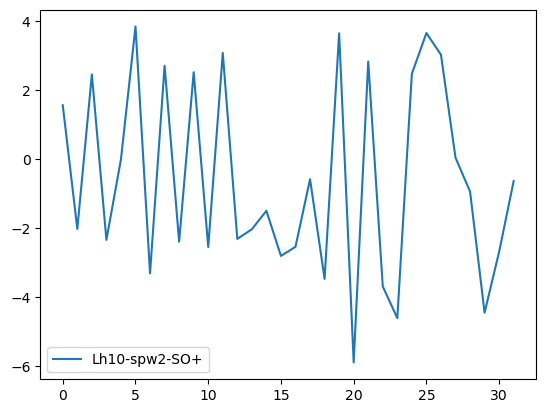

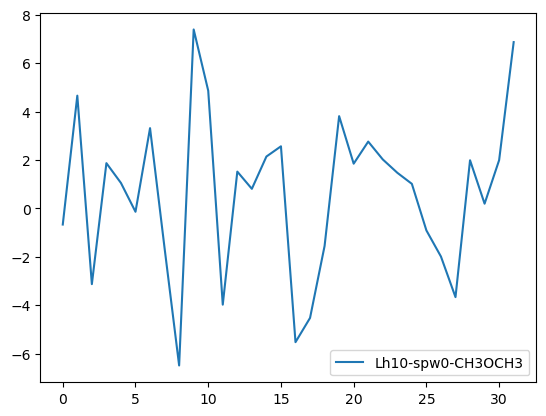

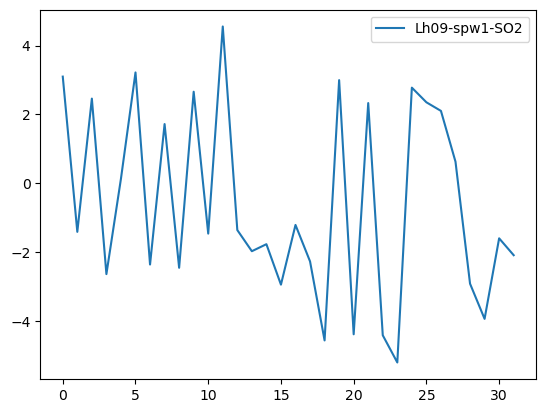

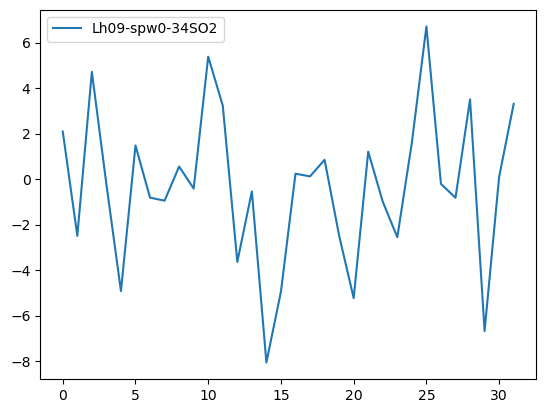

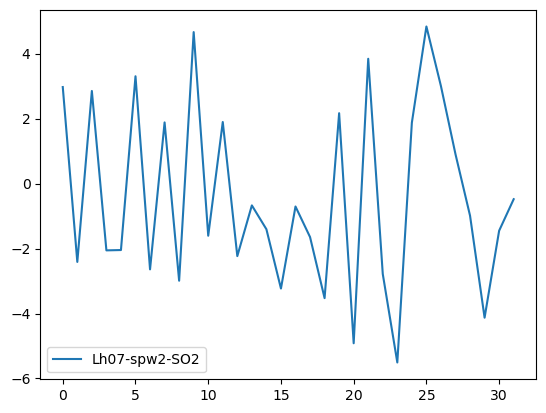

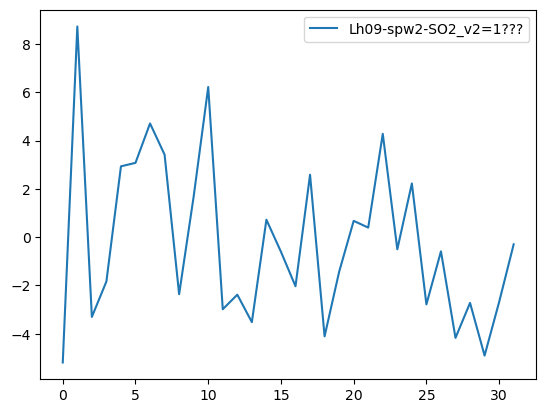

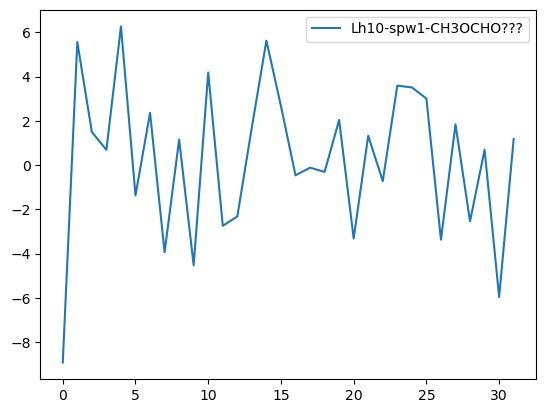

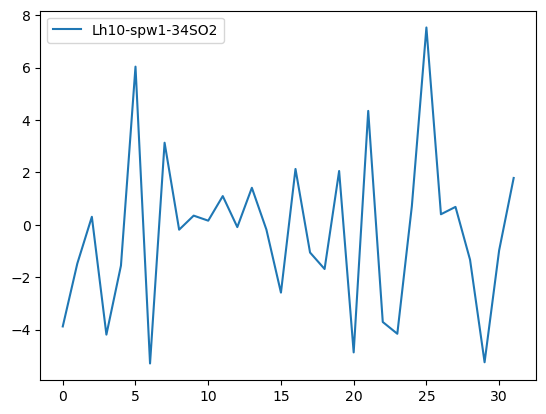

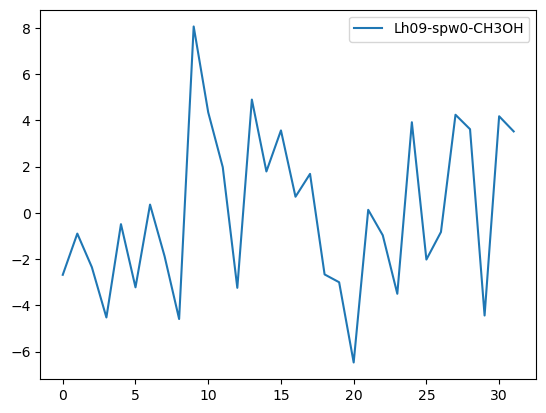

In [16]:
for i in range(10): 
    plt.plot(features[i],label=names_all[i])
    plt.legend()
    plt.show()

In [9]:
# 形状区分源
marker=[]
for n in range(len(names_all)):
    if names_all[n][0:4]=='Lh07':
        marker.append("o")
    if names_all[n][0:4]=='Lh09':
        marker.append("^")
    if names_all[n][0:4]=='Lh10':
        marker.append("s")


In [10]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE,MDS, Isomap,LocallyLinearEmbedding,SpectralEmbedding
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from adjustText import adjust_text

In [11]:
spec=SpectralEmbedding(n_components=3)
digits_spec=spec.fit_transform(features)

In [12]:
# 颜色区分分子
color_map = {'33SO2':'#000000', '13CH3OH???':'#FF0000', 'CO':'#00FF00', 
             'HC15N':'#0000FF', 'CH3OH':'#FFFF00','H13CO+':'#00FFFF','SO+':'#FF00FF',
             'SiO':'#FFA500', 'SO2':'#FFC0CB', 'HCO+':'#FFA07A', 'SO':'#A9A9A9', 'CH3OCH3':'#8B0000',
             '34SO2':'#ADD8E6', 't-HCOOH':'#90EE90', 'HC3N':'#D8BFD8','CH3OCHO???':'#4B0082','NS???':'#4B0082','SO2_v2=1???':'#4B0082',
            'H37gamma':'#483D8B'}

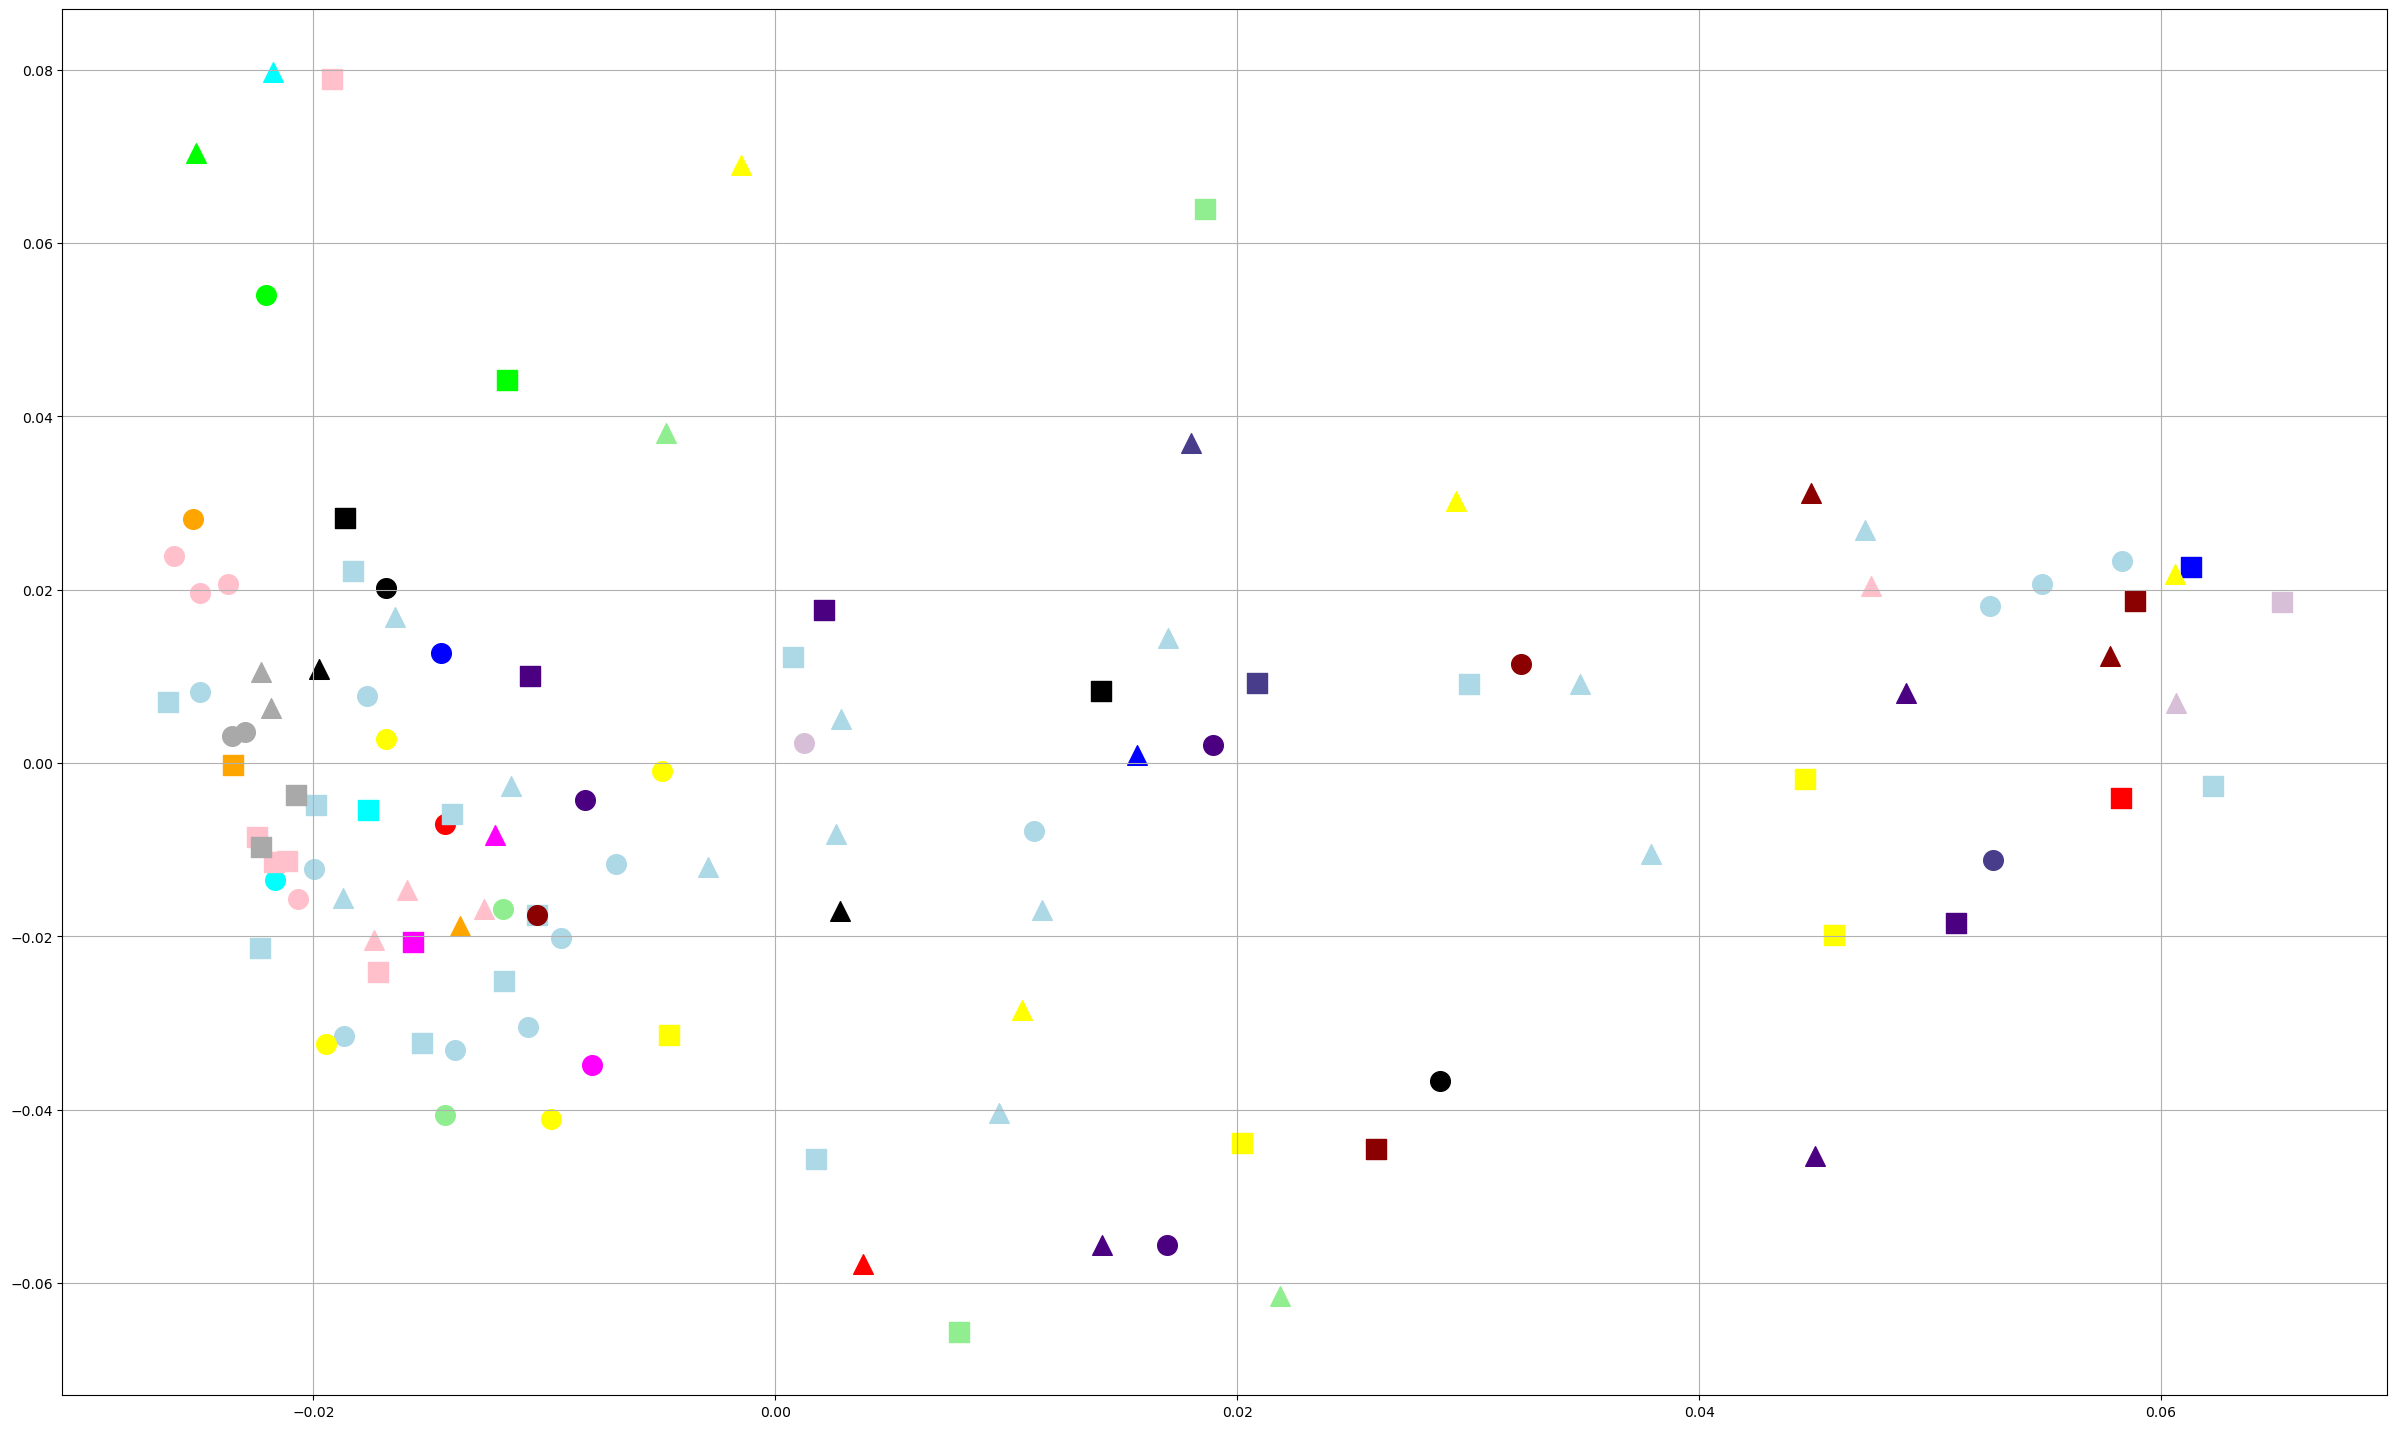

In [13]:
# SpectralEmbedding1
plt.figure(figsize=(30,18))
plt.grid()
# plt.xlim(digits_spec[:,0].min(),digits_spec[:,0].max()+1)
# plt.ylim(digits_spec[:,1].min(),digits_spec[:,1].max()+1)
#plt.xlim(-0.2,0.2)
for i in range(len(digits_spec)):
#     plt.text(digits_spec[i,0],digits_spec[i,1],str(new_name[i]),
#              color=colors[i],
#              fontdict={'weight':'bold','size':15})
    plt.scatter(digits_spec[i, 0], digits_spec[i, 1],s=200, color=color_map[names_all[i][10:]], marker=marker[i],label=names_all[i])
    
# new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_spec[:, 0], digits_spec[:, 1], names_all)]
# adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))

# plt.legend(ncol=3)

plt.savefig('C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\picture\\SE_VAE.png')  # 默认保存为PNG格式
plt.show()
plt.close()  # 关闭图形，释放内存